In [1]:
import pandas as pd
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql.functions import col
from pyspark.sql import functions as F

from igraph import Graph
from pyspark.sql.window import Window
from pyspark.sql.functions import col

from functools import reduce
from pyspark.sql.functions import collect_set, min as min_, expr,array_min,max
from pyspark.sql.functions import lit

from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, ArrayType,StructType,StructField, BooleanType

import pandas as pd
import glob

import time

import matplotlib.pyplot as plt

from pyspark.sql.types import BooleanType


In [2]:
import os
os.environ["SPARK_HOME"] =  "/root/anaconda3/lib/python3.9/site-packages/pyspark" 
os.environ["JAVA_HOME"] ="/usr"

# Lancer spark

In [3]:
findspark.init() 

def demarrer_spark(NB_CORES):
  local = f"local[{NB_CORES}]"
  # le parametre spark.local.dir indique le repertoire contenant les données temporaires ecrites sur disque lorsque le shufle ne tient pas en memoire
  appName = "PLDAC"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "320G").\
  set("spark.driver.memory","320G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.driver.maxResultSize", "20G").\
  set("spark.local.dir", "/data/bd/spark/tmp").\
  set("spark.sql.execution.arrow.pyspark.enabled", "true")
    

# # to allow sharing in memory arow format between pandas and spark : speeds up the creation of a spark df from a pandas df
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    
  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (NB_CORES coeurs)
  shuffle_partitions = 3 * NB_CORES
  print("shuffle", shuffle_partitions)
  spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))    

  print("session démarrée, son id est ", sc.applicationId)
  return spark


# Comparaison du temps de lecture des fichier avec plusieurs degree de parallélisme

In [4]:
import time
def read_files(partition_folder,nb_partition ):
   
    def read_file(partition_file) :
        #print(partition_file)
        try:
            df = pd.read_parquet(partition_file)
            return True
        except Exception as e:
            return False

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    read_file_udf = F.udf(read_file,  BooleanType())
    read_files_df = df.withColumn(
        "read_bool",
        read_file_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            )
        )
    )
    
    return read_files_df

## Temps de calcul d'une lecture de fichiers : # RACHA :


In [6]:
spark = demarrer_spark(60)
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

shuffle 180
session démarrée, son id est  local-1712392800788


In [7]:
read_files_df = read_files(partition_folder , 60)

In [8]:
import time 
file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/read_files_df"
start_time = time.time()
read_files_df.write.mode("overwrite").parquet(file_path)
print(time.time() - start_time)

11.047338008880615


In [13]:

import numpy as np
degree_parallelisme = range(1,60,10)
times_moy = []
for d in degree_parallelisme:
    times=[]
    for i in range(15):
        read_files_df = read_files(partition_folder , d)
        start_time = time.time()
        read_files_df.write.mode("overwrite").parquet(file_path)
        times.append(time.time() - start_time)
    times_moy.append(np.mean(times))
    
    

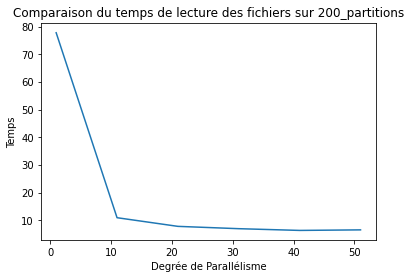

In [15]:
plt.plot(degree_parallelisme, times_moy)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

#clculer la moyenne avec le write

In [16]:
spark.stop()

## Variation du degree de parallélisme : #ANYES

### Le graph a était partitionné en 200 partitions

In [24]:
import time
times = []

degree_parallelisme = [10 ,20,  30, 40,  50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/*"
     read_files_df = read_files(partition_folder , d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()

shuffle 30
session démarrée, son id est  local-1712160474618


shuffle 60
session démarrée, son id est  local-1712160485284


shuffle 90
session démarrée, son id est  local-1712160492560


shuffle 120
session démarrée, son id est  local-1712160499412


shuffle 150
session démarrée, son id est  local-1712160505684


shuffle 180
session démarrée, son id est  local-1712160512355


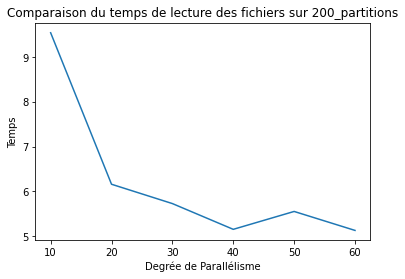

In [25]:
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

#clculer la moyenne avec le write

shuffle 30
session démarrée, son id est  local-1712159606828


shuffle 60
session démarrée, son id est  local-1712159618744


shuffle 90
session démarrée, son id est  local-1712159626632


shuffle 120
session démarrée, son id est  local-1712159633634


shuffle 150
session démarrée, son id est  local-1712159640026


shuffle 180
session démarrée, son id est  local-1712159646225


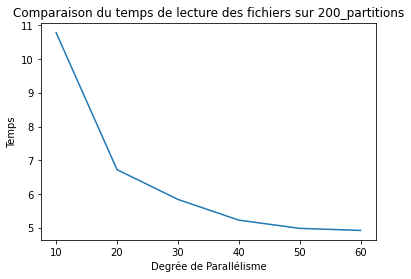

In [17]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/*"
     read_files_df = read_files(partition_folder , 3*d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

### Le graph a était partitionné en 60 partitions

shuffle 30
session démarrée, son id est  local-1712159831546


shuffle 60
session démarrée, son id est  local-1712159842356


shuffle 90
session démarrée, son id est  local-1712159849705


shuffle 120
session démarrée, son id est  local-1712159856414


shuffle 150
session démarrée, son id est  local-1712159862756


shuffle 180
session démarrée, son id est  local-1712159869542


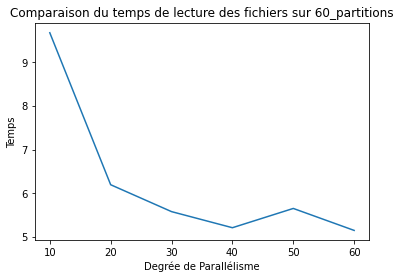

In [19]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/60_partitions/*"
     read_files_df = read_files(partition_folder , d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 60_partitions') 

plt.show()

# Comparaison du temps de calcul des composantes partielles : # RACHA

In [47]:
def calculate_partition_components(partition_folder , nb_partition):
   
    def components(partition_file, num_file , d) :
        # print(partition_file)
        df = pd.read_parquet(partition_file )
        g = Graph.TupleList(df[['query_id', 'target_id']].itertuples(index=False), directed=False)
        connected_components = g.connected_components()
        node_ids=[]
        for component in connected_components:
            node_ids.append([g.vs[node_index]['name'] for node_index in component])
        #on trie en fonction de la taille 
        composantes_triees = sorted(node_ids, key=len, reverse=True)
        # Créer une liste de lignes pour chaque composante
        rows = []
        for i, component in enumerate(composantes_triees):
            for seqid in component:
                rows.append((seqid , i)) 
                
        # result_df = pd.DataFrame(rows, columns=['seqid', 'component'])
        # file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_{num_file}.parquet"
        # result_df.to_parquet(file_path, index=False)

        return file_path

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    #data = [(file,) for file in os.listdir(partition_folder)]
    # data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]
    data = [(i,) for i in range(200)]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    schema_components = StructType([
        StructField("seqID", StringType(), nullable=False),
        StructField("component_id", IntegerType(), nullable=False)
    ])
    components_udf = F.udf(components, StringType())
    #df_with_components = df.withColumn("components", components_udf(F.concat(F.lit(partition_folder+"/"), df["file"])))
    df_with_components = df.withColumn(
        "components",
        components_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            ) , 
            df["file"],
            F.lit(nb_partition)
        )
    )
    
    return df_with_components

In [48]:
spark = demarrer_spark(60)

shuffle 180
session démarrée, son id est  local-1712401023419


In [49]:
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

In [50]:
df_with_component = calculate_partition_components(partition_folder , 60)

In [51]:
start_time = time.time()
directory_path =f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components"
# df_with_component.write.mode("overwrite").parquet(directory_path)
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


60.28257203102112


In [52]:
df_with_component = calculate_partition_components(partition_folder , 8)
start_time = time.time()
directory_path =f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components"
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


317.6276843547821


In [55]:
df_with_component = calculate_partition_components(partition_folder , 20)
start_time = time.time()
directory_path =f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components"
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


77.11013054847717


In [54]:
df_with_component = calculate_partition_components(partition_folder , 60)
start_time = time.time()
directory_path =f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components"
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


56.03961229324341


In [57]:

degree_parallelisme = range(1,60,10)
times_moy = []
times=[]

for d in degree_parallelisme:
    # for i in range(5):
    df_with_component = calculate_partition_components(partition_folder , d)
    start_time = time.time()
    df_with_component.write.mode("overwrite").parquet(directory_path)
    times.append(time.time() - start_time)
    # times_moy.append(np.mean(times))
    
    

ValueError: x and y must have same first dimension, but have shapes (6,) and (10,)

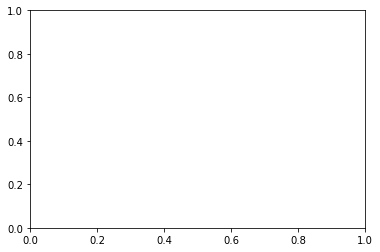

In [62]:
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps de calcul des composantes')
plt.title('Comparaison du Temps de calcul des composantes sur 200_partitions') 

plt.show()

#clculer la moyenne avec le write

In [61]:

degree_parallelisme = range(1,60,10)
times_moy = []
times=[]

for d in degree_parallelisme:
    print(d)
    times = []
    for i in range(10):
        df_with_component = calculate_partition_components(partition_folder , d)
        start_time = time.time()
        df_with_component.write.mode("overwrite").parquet(directory_path)
        times.append(time.time() - start_time)
    times_moy.append(np.mean(times))
    
    

1


11


21


31


41


51


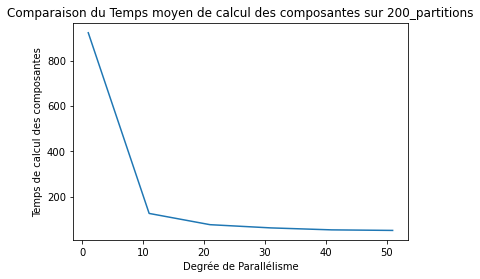

In [63]:
plt.plot(degree_parallelisme, times_moy)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps de calcul des composantes')
plt.title('Comparaison du Temps moyen de calcul des composantes sur 200_partitions') 

plt.show()

#clculer la moyenne avec le write

In [38]:
spark.stop()

## G' : # RACHA :

In [64]:
def components_2(edges):
    # Créer un graphe à partir des arêtes
    g = Graph.TupleList(edges, directed=False)
    
    connected_components = g.connected_components()
    node_ids=[]
    for component in connected_components:
        node_ids.append([g.vs[node_index]['name'] for node_index in component])
    #on trie en fonction de la taille 
    composantes_triees = sorted(node_ids, key=len, reverse=True)
    # Créer une liste de lignes pour chaque composante
    rows = []
    for i, component in enumerate(composantes_triees):
        for seqid in component:
            rows.append(Row(partial_component=seqid ,component=i ))
    
    # Créer un DataFrame Spark à partir de la liste de lignes
    result_df = spark.createDataFrame(rows)
    return result_df

In [12]:
def calculate_components(folder_partition ):
    # Claclul des composantes partielles dans chaque partition
    df_with_components = calculate_partition_components(folder_partition)
    df_exploded = df_with_components.select('file',  explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))
    
    # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")

    # new_df = df_split.select(
    #             'seqID',
    #             concat(col('file'), lit(':'), col('component_id')).alias('new_component_id')
    #         )
    
    #cration d'un graph ou chaque noeud est le numero d'une composante (new_graph)

    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))

    # components_per_node = new_df \
    #     .groupby("seqID") \
    #     .agg(collect_set("new_component_id").alias("components")) \
    #     .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()
  
    
    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")

    #calcul des composantes sur le nouveau graph
    edges =new_graph.select('src', 'dst').collect()
    composantes_df = components_2(edges)

    composantes_df_exploded = composantes_df \
            .groupby("component") \
            .agg(collect_set("partial_component").alias("partial_components")) \
            .withColumn("min_partial_component", array_min("partial_components")) \
            .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")
    
    #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_nodeID_only"
    result.repartition(1).write.mode("overwrite").parquet(file_path)
    
    return result

# ANyes

In [ ]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"
     df_with_component = calculate_partition_components(partition_folder , d)
     start_time = time.time()
     # On lance une action   
     c = df_with_component.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()


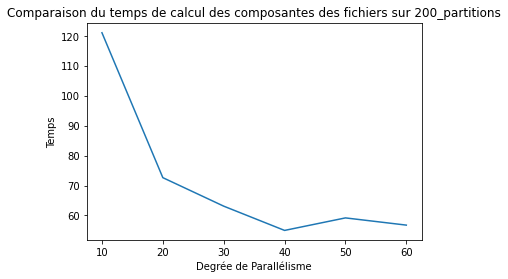

In [90]:
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul des composantes des fichiers sur 200_partitions') 

plt.show()